In [1]:
from surv_traj.model import SurvTraj
import numpy as np
import matplotlib.pyplot as plt
from surv_traj.utility import get_str_array, get_traj_plot_ci
from IPython.display import clear_output

%matplotlib inline

The next section shows the survival data generation example

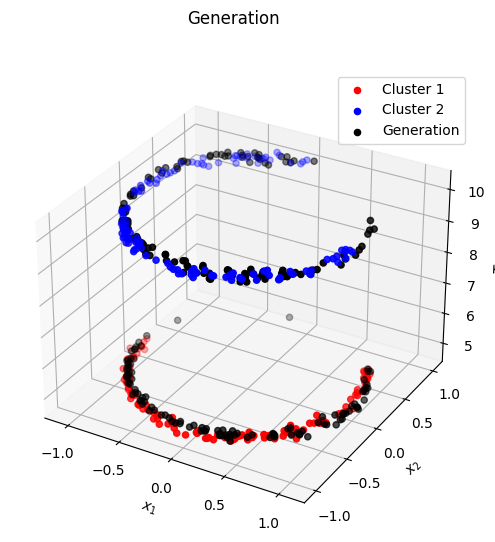

In [2]:
# the data preparing
spiral = lambda tau: np.stack((np.sin(tau), np.cos(tau)), axis=-1)
n_per_cls = 120
noise_lvl = 0.02
pi = np.pi
tau_bounds = [
    (pi / 3, 3 * pi / 2),
    (pi / 2, 4 * pi / 2)
]

responses = [
    lambda tau: 5 + np.random.normal(0, 0.1, tau.shape),
    lambda tau: 10 + np.random.normal(0, 0.1, tau.shape),
]

x_train_list = []
t_train_list = []
clr = ['r', 'b']
x_clusters = []
t_clusters = []
for i in range(len(tau_bounds)):
    tau = np.random.uniform(*tau_bounds[i], (n_per_cls))
    X = spiral(tau)
    X += np.random.normal(0, noise_lvl, X.shape)
    x_train_list.append(X)
    t = responses[i](tau)
    t_train_list.append(t)
    x_clusters.append(X)
    t_clusters.append(t)
x_train = np.concatenate(x_train_list, 0)
d_train = np.random.binomial(1, 0.8, x_train.shape[0])
t_train = np.concatenate(t_train_list, 0)
y = get_str_array(t_train, d_train)

def draw_train_set_3d(name, z_name):
    fig = plt.figure(dpi=100, figsize=(6, 6))
    fig.suptitle(name)
    ax3d = fig.add_subplot(111, projection='3d')
    ax3d.set_xlabel('$x_1$')
    ax3d.set_ylabel('$x_2$')
    ax3d.set_zlabel(z_name)
    for i in range(2):
        ax3d.scatter(*x_clusters[i].T, t_clusters[i], c=clr[i], label='Cluster ' + str(i + 1))
    return fig, ax3d

# model parameters
params_kw = {
    'vae_kw': {
    'latent_dim': 8,
    'regular_coef': 40,
    'sigma_z': 1
},
    'samples_num': 48,
    'batch_num': 16,
    'epochs': 60,
    'lr_rate': 2e-3,
    'c_ind_weight': 0.5,
    'vae_weight': 1.5,
    'traj_weight': 0.5,
    'likelihood_weight': 0.05,
    'c_ind_temp': 1,
    'gumbel_tau': 1.0,
    'train_bg_part': 0.6,
    'batch_load': None,
    'device': 'cuda:0',
}

# training the model
model = SurvTraj(**params_kw)
model.fit(x_train, y)
clear_output()

# generating new points
x_e_all, T_gen, D_all = model.predict_recon(x_train)

# drawing the result
fig, ax3d = draw_train_set_3d('Generation', '$T_{gen}$')
ax3d.scatter(*x_e_all.T, T_gen, c='k', label='Generation')
ax3d.legend()
plt.show()

The next section shows the trajectories generation

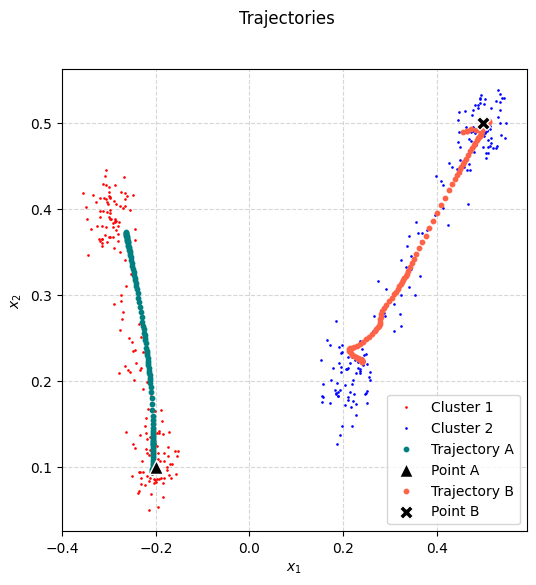

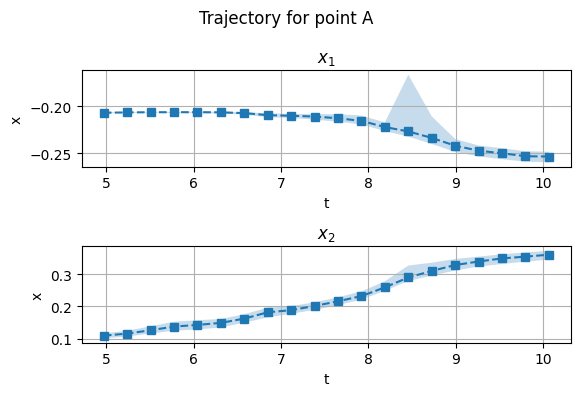

In [3]:
# the data preparing
cls_centers = 0.1 * np.asarray(
    [
        [-2, 1],
        [-3, 4],
        [2, 2],
        [5, 5]
    ]
).astype(np.double)
times = np.asarray(
    [
        5,
        10,
        5,
        10
    ]
).astype(np.double)
n_per_cls = 60

cls_points = np.stack(
    [np.random.normal(c, 0.025, (n_per_cls, cls_centers.shape[1])) for c in cls_centers], 0)
x_train = []
t_train = []
x_clusters = []
t_clusters = []
clr = ['r', 'b']
for i in range(0, cls_centers.shape[0], 2):
    mix_coef = np.random.uniform(0, 1, (n_per_cls, 1))
    X = cls_points[i] * mix_coef + cls_points[i + 1] * (1 - mix_coef)
    X += np.random.normal(0, 0.005, X.shape)
    x_train.append(X)
    mix_coef = mix_coef.ravel()
    t = times[i] * mix_coef + times[i + 1] * (1 - mix_coef)
    t += np.random.normal(0, 0.1, t.shape)
    t_train.append(t)
    cluster_points = np.concatenate((X, cls_points[i], cls_points[i + 1]), axis=0)
    x_clusters.append(cluster_points)
    cluster_t = np.concatenate((t, np.tile(times[i], n_per_cls), np.tile(times[i + 1], n_per_cls)))
    t_clusters.append(cluster_t)
x_train = np.concatenate(x_train, 0)
x_train = np.concatenate((x_train, cls_points.reshape(-1, cls_centers.shape[1])), 0)
d_train = np.random.binomial(1, 0.8, x_train.shape[0])
t_train = np.concatenate(t_train, 0)
t_train = np.concatenate((t_train, np.repeat(times, n_per_cls)), 0)
y = get_str_array(t_train, d_train)

def draw_train_set_2d(name):
    fig, ax = plt.subplots(1, 1, dpi=100, figsize=(6, 6))
    fig.suptitle(name)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    for i in range(2):
        ax.scatter(*x_clusters[i].T, c=clr[i], s=0.8, label='Cluster ' + str(i + 1))
    ax.xaxis.set_zorder(-100)
    ax.yaxis.set_zorder(-100)
    ax.grid(linestyle='--', alpha=0.5)
    return fig, ax

# model parameters
params_kw = {
    'vae_kw': {
    'latent_dim': 8,
    'regular_coef': 40,
    'sigma_z': 1
},
    'samples_num': 48,
    'batch_num': 16,
    'epochs': 80,
    'lr_rate': 2e-3,
    'c_ind_weight': 0.5,
    'vae_weight': 2.0,
    'traj_weight': 1.0,
    'likelihood_weight': 0.05,
    'c_ind_temp': 1,
    'gumbel_tau': 1.0,
    'train_bg_part': 0.6,
    'batch_load': None,
    'device': 'cuda:0',
}

# training the model
model = SurvTraj(**params_kw)
model.fit(x_train, y)
clear_output()

exp_points = np.concatenate([
        cls_centers[None, 0],
        cls_centers[None, 3]
    ], axis=0,
)

# predicting the trajectories
t_traj = np.linspace(t_train.min(), t_train.max(), 100)
t_traj = np.tile(t_traj[None, :], (len(exp_points), 1))
x_explain = model.predict_trajectory(exp_points, t_traj, multi_sampling=False)

markers = ['^', 'X']
lab_list = ['A', 'B']
clr_t = ['teal', 'tomato']
fig, ax = draw_train_set_2d('Trajectories')
for i in range(2):
    ax.scatter(*x_explain[i].T, s=10, c=clr_t[i], label='Trajectory ' + lab_list[i])
    ax.scatter(*exp_points[i].T, s=100, c='k', edgecolors='w', zorder=100,
                marker=markers[i], label='Point ' + lab_list[i])
ax.legend()


fig, ax = get_traj_plot_ci(model, exp_points[0], np.linspace(t_train.min(), t_train.max(), 20))
fig.suptitle('Trajectory for point A')
plt.show()

The next section shows the survival regression abilities

In [4]:
from datasets import Veterans
from models import SurvForestWrapper, SurvTrajWrapper

# import real data
ds = Veterans(val_part=0.3, test_part=0.4, seed=123)
x_train_nn, y_train_nn, x_test, y_test, x_val_nn, y_val_nn = ds.get_ttv_set()

# train the SurvVAE model and the rival one
params_kw = {
    'latent_dim': 14,
    'regular_coef': 40,
    'sigma_z': 1,
    'samples_num': 48,
    'batch_num': 16,
    'epochs': 200,
    'lr_rate': 2e-3,
    'c_ind_weight': 1.0,
    'vae_weight': 0.5,
    'traj_weight': 0.5,
    'likelihood_weight': 0.05,
    'c_ind_temp': 1,
    'gumbel_tau': 1.0,
    'train_bg_part': 0.6,
    'batch_load': None,
    'device': 'cuda:0',
}
surv_vae = SurvTrajWrapper(**params_kw)
surv_vae.fit(ds)

rnd_forest = SurvForestWrapper(folds_n=3, cv_iters=10, n_jobs=8, seed=123)
rnd_forest.fit(ds)

clear_output()

print('Survival VAE C index score:', surv_vae.score(ds))
print('Random Survival Forest C index score:', rnd_forest.score(ds))

Survival VAE C index score: 0.7285198555956679
Random Survival Forest C index score: 0.7187725631768953
